In [1]:
import scipy.stats
import scipy.special
from scipy.stats import norm 

import numpy as np
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern,ConstantKernel,WhiteKernel

from warnings import filterwarnings
filterwarnings('ignore')

Use the same objective function as Gaussian process and acquisition function visulization.

But this time we consider noise.

In [2]:
#Objective function
def f(x, add_noise=False):
    func=-1*2*np.sin(x+1)*x
    if add_noise:
        noise=np.random.randint(-10,10)*1e-3
        func+=noise
    return func

To simplify the process, I only perform expected improvement here.

The suggest function is the same as the acquisition function visualization.

In [3]:
def suggest(gpr,y_sample,bound,n):
    def acquisition(x):
        x=np.array(x).reshape(1,-1)
        mu,std = gpr.predict(x,return_std=True)
        best_y=y_sample.min()
        #if acq=='EI': #Expected Improvement
        gamma=(best_y-mu)/std
        return -((best_y-mu)*norm.cdf(gamma)+norm.pdf(gamma))
        #elif acq=='PI': #Probability Improvement
        #return -norm.cdf(best_y,loc=mu,scale=std)
        #elif acq=='LCB': #confidence bound (Lower for minimization)
        #return mu -1.6*std
    x_est=np.linspace(bound[0][0],bound[0][1],100).reshape(100,)
    y_acq=[]
    for i in range(100):
        y_acq.append(-1*acquisition(x_est[i]))
    Y_acq=np.array(y_acq)
    x_next=x_est[np.argmax(Y_acq)]
    plt.plot(x_est,Y_acq,color="C{}".format(n))
    plt.scatter(x_next,Y_acq.max(),
        s=50,marker='s',color="C{}".format(n))#,label='Maximum'
    #plt.title(f'Acquisition Function')
    plt.xlabel('$x$')
    plt.ylabel('Acquisition($x$)')
    #plt.legend(loc='upper right')
    return x_next,Y_acq

Generate Sample data

In [4]:
x=np.linspace(-10,10,100) #search range
#new point for further prediction
x_new=np.linspace(-10,10,100).reshape(100,1)
#sample (includes edge points in samples)
x_=20*np.random.rand(4,1)-10
x_=np.vstack((np.array(-10),np.array(10),x_))
y_=f(x_)

Define a function for generating multiple Gaussian process regressors later.

This time I also include noise and hyperparameters in the covariance function like the original paper did.

In [5]:
def rand_gpr(x,y,theta,kernel="Matern"):
    a=ConstantKernel(theta)
    nu=np.random.randint(-10,10)*1e-4
    if kernel=="Matern":
        k=a**2*Matern(nu=2.5,length_scale=1,length_scale_bounds=(1e-7,1e5))
        +nu*WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))
    elif kernel=="SqrExp":
        k=a**2*RBF(length_scale=1,length_scale_bounds=(1e-7,1e5))
        +nu*WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))
    return GaussianProcessRegressor(kernel=k,random_state=1000).fit(x,y)


Randomly generate 1000 Gaussian process regressor and fit them with the sample data.

In [6]:
n_gpr=1000
theta=np.random.rand(n_gpr)*10
gp=[]
for i in range(n_gpr):
    gp.append(rand_gpr(x_,y_,theta[i],kernel="Matern"))

Define the searching area, integrate all the acquisition function value at the same point 

and divided by the number of regressor.(calculating the expectation)

Then plot them to compare the difference.

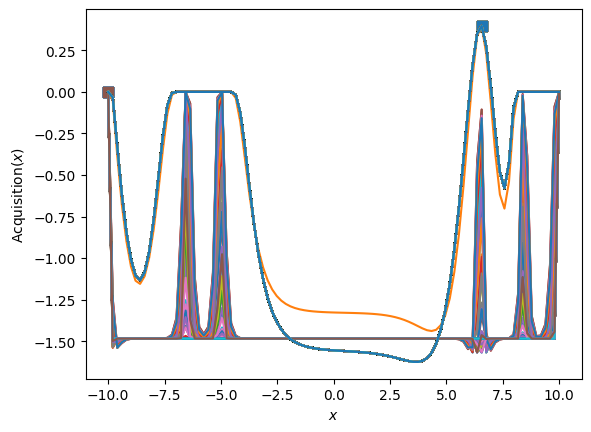

Next point to evaluate: x= 6.565656565656564


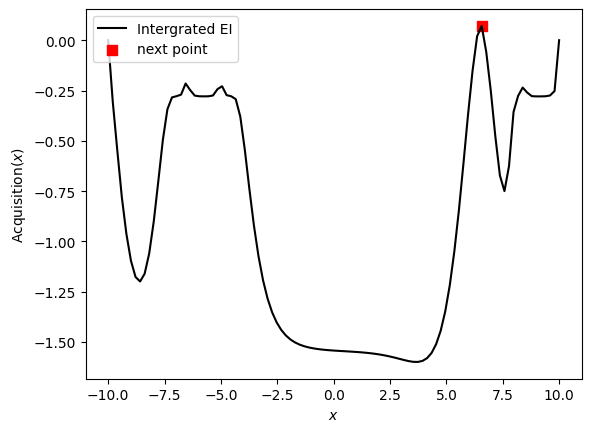

In [7]:
bound=[(-10,10)]
Y1=np.zeros((100,1))
for i in range(n_gpr):
    x_next,Y=suggest(gp[i],y_,bound,i+1)
    Y1=Y1+Y
plt.show()
Y_int=Y1/n_gpr #Integrated EI
x_est=np.linspace(bound[0][0],bound[0][1],100).reshape(100,)
Y_best=Y_int.max()
x_best=x_est[np.argmax(Y_int)]
print('Next point to evaluate: x=',x_best)
plt.plot(x_est,Y_int,'k-',label='Intergrated EI')
plt.scatter(x_best,Y_best,s=50,c='r',marker='s',label='next point')
plt.xlabel('$x$')
plt.ylabel('Acquisition($x$)')
plt.legend(loc='upper left')
